In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import ipywidgets as wi
from tqdm.notebook import tqdm
import scipy as sc
import scipy.optimize as opt
import scipy.linalg as la

In [2]:
testPath = os.path.join('Dataset', 'Bikes.avi')

In [3]:
max_num = 30
def loadClip(fullpath=testPath):
    cap = cv2.VideoCapture(fullpath);
    if(not cap.isOpened()):
        return
    try:
        num_image=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         print(num_image)
        num_image = max_num if (num_image>max_num) else num_image; #only first 30
        imgs =[cap.read()[1][:,:,::-1] for _ in range(num_image)]
        return imgs
    finally:
        cap.release()

#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [4]:
imgs = loadClip()
imgs = [cv2.resize(img, (0, 0), fx=0.2, fy=0.2) for img in imgs]
grays = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
# plt.imshow(grays[0], cmap='gray')

In [5]:
ref = grays[0]
ref_features = cv2.goodFeaturesToTrack(ref, 20000, 1e-10, 5)[:, 0, :]

In [6]:
inlier_mask = np.ones(ref_features.shape[0], dtype='bool')

In [7]:
def plot_with_keypoints(i):
    plt.imshow(imgs[i])
    
    features = cv2.goodFeaturesToTrack(grays[i], 20000, 1e-10, 5)[:,0,:]  
    step = 10
    plt.scatter(features[::step,0], features[::step,1], s=1, c='r')
    plt.axis('off')
_ = wi.interact(plot_with_keypoints, i=wi.IntSlider(0,0,len(grays)-1))

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [8]:
corners_fwd, corners_bwd, status_fwd, status_bwd, err_fwd, err_bwd = None, None, None, None, None, None
_ = cv2.calcOpticalFlowPyrLK(ref, grays[1], ref_features, None)

In [9]:
features = []
inlier_mask = np.ones((len(ref_features),1), dtype='bool')
corners_ref = ref_features
for i in tqdm(range(1, len(grays))):
    corners_fwd, st_fwd, err = cv2.calcOpticalFlowPyrLK(ref, grays[i], corners_ref, None)
    corners_bwd, st_bwd, err = cv2.calcOpticalFlowPyrLK(grays[i], ref, corners_fwd, None)
    bidir_err = np.linalg.norm(corners_ref-corners_bwd, axis=1, keepdims=True)
    inlier_mask = inlier_mask & (st_fwd!=0) & (st_bwd!=0) & (bidir_err<0.1)
    features.append(corners_fwd)
inlier_mask = inlier_mask.flatten()

In [10]:
n_features = len(ref_features)
n_frames = len(features)
print(n_features, n_frames)

1670 29


In [11]:
sel_features = np.array(features)[:, inlier_mask]
sel_ref_features = ref_features[inlier_mask]
sh = sel_features.shape

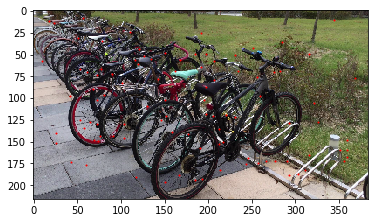

In [13]:
plt.imshow(imgs[0])
step = 10
plt.scatter(sel_ref_features[::step,0], sel_ref_features[::step,1], s=1, c='r')

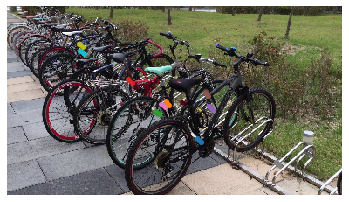

In [14]:
plt.imshow(imgs[0])
# plt.imshow(ref, cmap="Greys_r")
plt.axis("off")
step = 10

for i in range(min(sel_features.shape[1], 10)):
    plt.scatter(sel_features[::step, i, 0], sel_features[::step, i, 1], s=15)#, c='r')

In [15]:
frame = 10
ref_features = sel_ref_features
features = sel_features[frame] 

features_c = features - features.mean(axis=0)
ref_features_c = ref_features - ref_features.mean(axis=0) 
# https://en.wikipedia.org/wiki/Procrustes_analysis
up = features_c[:, 0]@ref_features_c[:, 1]-features_c[:, 1]@ref_features_c[:, 0]
down = features_c[:, 0]@ref_features_c[:, 0]-features_c[:, 1]@ref_features_c[:, 1]
theta = np.arctan2(up, down)

rot = np.array([[np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)]])


features_c = features_c@rot
print("Error before:", np.sum((features-ref_features)**2))
print("Error after:", np.sum((features_c-ref_features_c)**2))

Error before: 8879.578
Error after: 57.090736


In [164]:
sel_ref_features_n = sel_ref_features/(np.array([width, height])[None,:])
sel_features_n = sel_features/(np.array([width, height])[None,:])

In [165]:
ref_features = sel_ref_features_n
all_features = []
for frame in range(sel_features.shape[0]):
    features = sel_features_n[frame] 

    features_c = features - features.mean(axis=0)
    ref_features_c = ref_features - ref_features.mean(axis=0) 
    # https://en.wikipedia.org/wiki/Procrustes_analysis
    up = features_c[:, 0]@ref_features_c[:, 1]-features_c[:, 1]@ref_features_c[:, 0]
    down = features_c[:, 0]@ref_features_c[:, 0]-features_c[:, 1]@ref_features_c[:, 1]
    theta = np.arctan2(up, down)

    rot = np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])
    new = -features@rot
    new = np.concatenate((new, np.ones((new.shape[0], 1))), axis=1)
    
    
    all_features.append(new.T)
    
all_features = np.concatenate(all_features, axis=0)

U, s, Vh = la.svd(all_features)

c, d = U[:, 0], Vh[0, :]

In [166]:
def L(x, c, uv0, uv):
    """
    x - concatenated variables we try to find (optimize by them)
    c - image center coordinates in image space (width/2, height/2)
    uv0 - array of features coordinates for reference frame
    uv - array of features coordinates for the rest of frames
    
    """
    f, k1, k2 = x[:3] #camera intristic parameter (focus, distortion)
#     np.split()
    rx, ry, rz, tx, ty, tz = camera = np.hsplit(x[3:3+6*n_frames].reshape((n_frames, 6)), 6) #rotation/translation
    cx, cy = c 
    w = np.array(x[3+6*n_frames:]) #inverse_depths for each feature point
    uv0 = uv0 - c # center
    r20_ = np.linalg.norm(uv0/f)
    dist = 1 + k1*r20_ + k2*r20_*r20_
    uv0 = uv0*dist # account for distortion
    # get components for easier calculations?
    u0 = uv0[:, 0] 
    v0 = uv0[:, 1]
    # R(r_i)x_j+t_i
    p = [u0 - rz*v0 + f*ry + f*tx*w, 
         rz*u0 + v0 - f*rx + f*ty*w,
         -ry*u0 + rx*v0 + f + f*tz*w]
    
    # <>
    uvp = f*np.array(p[:2])/p[2] 
    # order
    uvp = np.transpose(uvp, (1, 2 ,0))
    
    # second term of loss
    uv = uv-c
    r2_ = np.linalg.norm(uv/f)
    dist = 1 + k1*r2_ + k2*r2_*r2_
    uv = uv*dist
    return (uv-uvp).ravel()

In [167]:
w_min=0.01
w_max=1.0
print(sh)
w = w_min + np.random.rand(sh[1]) * (w_max - w_min)
w.shape

(29, 963, 2)


(963,)

In [168]:
shape = height, width = grays[0].shape
c = np.array(shape)[::-1]/2

In [169]:
sel_ref_features.max(axis=0)

array([369., 205.], dtype=float32)

In [170]:
rt = np.zeros((n_frames, 6))
internal = f_init, k1_init, k2_init = [width if width>height else height, 0.0, 0.0]
# x = np.concatenate((internal, rt.ravel(), w))
x = np.concatenate((internal, rt.ravel(), d))

In [171]:
L(x, c, sel_ref_features, sel_features).shape

(55854,)

In [172]:
n = np.prod(sel_features.shape)
m = len(x)
A = sc.sparse.lil_matrix((n, m), dtype=int)
A.shape
A[:, :3] = 1
for i in range(n_frames):
    A[i*2*n_features:(i+1)*2*n_features, 3 + i*6:3 + (i+1)*6] = 1
st = 3 + n_frames*6
for j in range(0, A.shape[0]):
    A[2*j:2*(j+1), st + j%len(w)] = 1

In [180]:
rt = np.zeros((n_frames, 6))
internal = f_init, k1_init, k2_init = [width if width>height else height, 0.0, 0.0]
w = w_min + np.random.rand(sh[1]) * (w_max - w_min)
x = np.concatenate((internal, rt.ravel(), w))
# x = np.concatenate((internal, rt.ravel(), d))
def bundle_adjustment():
    return opt.least_squares(L, x, jac_sparsity=A,
                        loss='huber', verbose=2, xtol=None, #, x_scale='jac'
                        args=(c, sel_ref_features_n, sel_features_n))
res_w = bundle_adjustment()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9859e+00                                    6.90e+08    
       1              2         3.0179e+00      9.68e-01       4.60e-04       4.51e+08    
       2              4         2.0320e+00      9.86e-01       1.06e-04       1.17e+08    
       3              5         1.9150e+00      1.17e-01       1.06e-04       1.16e+08    
       4              6         1.8431e+00      7.19e-02       2.66e-05       4.09e+07    
       5              7         1.8321e+00      1.10e-02       6.64e-06       8.95e+06    
       6              8         1.8315e+00      5.66e-04       1.66e-06       2.35e+06    
       7             10         1.8315e+00      1.91e-05       1.04e-07       1.40e+05    
       8             14         1.8315e+00      4.58e-08       4.05e-10       6.82e+03    
       9             15         1.8315e+00      1.55e-07       1.01e-10       6.82e+03    

ValueError: attempt to get argmin of an empty sequence

In [174]:
rt = np.zeros((n_frames, 6))
internal = f_init, k1_init, k2_init = [width if width>height else height, 0.0, 0.0]
# x = np.concatenate((internal, rt.ravel(), w))
x = np.concatenate((internal, rt.ravel(), 0.2*d/d.max()+0.8*w))
def bundle_adjustment():
    return opt.least_squares(L, x, jac_sparsity=A,
                        loss='huber', verbose=2, xtol=None, #, x_scale='jac'
                        args=(c, sel_ref_features_n, sel_features_n))
res_d = bundle_adjustment()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9859e+00                                    6.90e+08    
       1              2         3.3528e+00      6.33e-01       4.95e-04       5.02e+08    
       2              3         2.0614e+00      1.29e+00       1.13e-04       1.14e+08    
       3              4         1.9051e+00      1.56e-01       1.24e-04       1.64e+08    
       4              5         1.7432e+00      1.62e-01       3.10e-05       5.40e+07    
       5              6         1.6950e+00      4.83e-02       3.10e-05       4.09e+07    
       6              7         1.6506e+00      4.44e-02       7.74e-06       8.88e+06    
       7              8         1.6471e+00      3.52e-03       7.74e-06       7.06e+06    
       8             12         1.6469e+00      1.51e-04       3.02e-08       4.39e+04    
       9             19         1.6469e+00      3.36e-09       1.85e-12       6.84e+03    

In [191]:
import pandas as pd

files = ["out_d",
         "out1_w",
         "out2_w",
         "out3_w",
         "out4_w",
         "out5_w"]

dfs = {}
for f in files:
    dfs[f] = pd.read_csv(f+".log", sep="\s+", skiprows=2, header=None, names=["Iteration", "Total nfev", "Cost", "Cost reduction", "Step norm", "Optimality"])

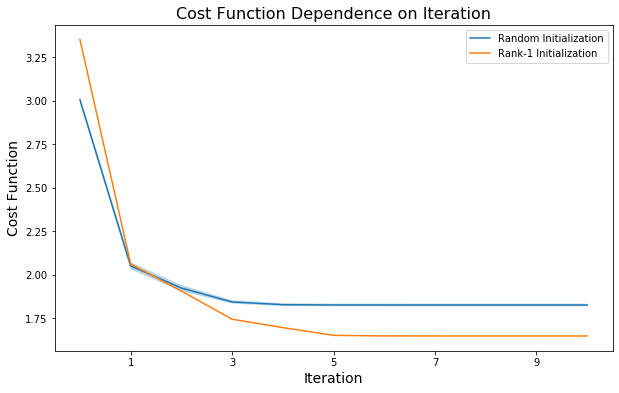

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

costs_w = []
min_len = 1000
for f in files:
    if f == "out_d": 
        continue
    costs_w.append(dfs[f]["Cost"].values)
    min_len = min(min_len, len(costs_w[-1]))
costs_d = dfs["out_d"]["Cost"].values 
costs_w = np.array([v[:len(costs_d)] for v in costs_w])
ax.set_xticks(range(1, min_len, 2))

ax.plot(costs_w.mean(axis=0), label="Random Initialization")
ax.fill_between(np.arange(len(costs_d)), 
                costs_w.mean(axis=0)-costs_w.std(axis=0), 
                costs_w.mean(axis=0)+costs_w.std(axis=0),
                alpha=0.3)
ax.plot(dfs["out_d"]["Cost"].values, label="Rank-1 Initialization")
ax.set_ylabel("Cost Function", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_title("Cost Function Dependence on Iteration", fontsize=16)

ax.legend()
plt.show()

fig.savefig("plot.pdf")
fig.savefig("plot.svg")

In [ ]:
cap = cv2.VideoCapture(0);
cap.isOpened()
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame)

cap.release()
cv2.destroyAllWindows()

In [ ]:
loadClip('Dataset/Bikes.avi')

In [ ]:
# cv2.startWindowThread()
cap = cv2.VideoCapture('Dataset/Bikes.avi')

while(cap.isOpened()):
    ret, frame = cap.read()
    print(frame.shape)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('title', gray)
    plt.show()
    input()
cap.release()
cv2.destroyAllWindows()